In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Configuration for synthetic workload analysis
synthetic_root_dir = '../result/synthetic2_result/'  # Update this path as needed
synthetic_fig_prefix = 'revision2/synthetic'

# Define the parameter ranges for synthetic workloads
DATASET_SIZES = [50000] #[1000, 5000, 10000, 50000, 100000]  # Update based on your actual data
QUERY_SIZES = [500, 1000, 2000, 5000]  # Update based on your actual data  
SELECTIVITIES = ['0.001', '0.005', '0.010', '0.020', '0.050', '0.100', '0.200', '0.500']  # Update based on your actual data
SYNTHETIC_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [4]:
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [5]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{int(row['num_threads'])}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
        key_upp = int(row['key_upper_bound'])
        if key_upp < 100000000:
            space_file += f"_{key_upp}"
        else:
            space_file += "_-1"
        fields.insert(-1, str(key_upp))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [6]:
def get_compute_space(space_f, root_dir=synthetic_root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [7]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=synthetic_root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [8]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=synthetic_root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=synthetic_root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [9]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df.fillna(-1, inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=synthetic_root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

# Synthetic Workload Analysis

Analysis for synthetic workload data with varying dataset sizes, query sizes, and selectivities.

In [10]:
def parse_synthetic_folder_name(folder_name):
    """
    Parse synthetic folder name with format: synthetic2_{datasetSize}_{querySize}_{selectivity}_{methodName}_{suffix}
    Returns a dictionary with parsed parameters or None if parsing fails.
    """
    try:
        parts = folder_name.split('_')
        if len(parts) < 5 or not parts[0].startswith('synthetic'):
            return None
            
        dataset_size = int(parts[1])
        query_size = int(parts[2])
        selectivity = float(parts[3])
        method_name = parts[4]
        suffix = '_'.join(parts[5:]) if len(parts) > 5 else ''
        
        return {
            'dataset_size': dataset_size,
            'query_size': query_size,
            'selectivity': selectivity,
            'method_name': method_name,
            'suffix': suffix,
            'folder_name': folder_name
        }
    except (ValueError, IndexError):
        return None

In [11]:
def build_synthetic_stats_filename(folder_info, previous_version=False):
    """
    Build the stats filename for synthetic workload based on folder info.
    Adapts the existing build_stats_filename logic for synthetic data.
    """
    method = folder_info['method_name']
    
    # Handle method name variations
    if 'parallel' in method:
        method = method.split('-')[0]
    if 'VGGraph-Greedy' in method:
        method = 'VGGRAPH'
    
    # Basic fields: method, threads, gram_size, selectivity, stats.csv
    # For synthetic, we'll use default values since they may not be in folder name
    fields = [method, '1', '4', str(folder_info['selectivity']), 'stats.csv']  # Default thread=1, gram_size=4
    
    if 'Trigram' in method:
        fields[2] = '-1'  # Trigram doesn't use gram_size
    
    # Space file for memory usage
    space_file = f"time_report_{method.lower()}_t1"
    if 'Trigram' not in method:
        space_file += f"_c{folder_info['selectivity']}"
    if method in ['FREE', 'VGGraph', 'VGGRAPH']:
        space_file += f"_n{fields[2]}"
    space_file += '.txt'
    
    return '_'.join(fields), space_file

In [12]:
def discover_synthetic_folders(root_dir):
    """
    Discover all synthetic workload folders and parse their parameters.
    Returns a list of folder info dictionaries.
    """
    folder_infos = []
    
    if not os.path.exists(root_dir):
        print(f"Warning: Directory {root_dir} does not exist")
        return folder_infos
    
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path) and item.startswith('synthetic'):
            folder_info = parse_synthetic_folder_name(item)
            if folder_info:
                folder_infos.append(folder_info)
            else:
                print(f"Warning: Could not parse folder name: {item}")
    
    print(f"Found {len(folder_infos)} synthetic workload folders")
    return folder_infos

In [13]:
def build_synthetic_result_df(root_dir):
    """
    Build result dataframe for synthetic workloads.
    Adapts the existing build_result_df function for synthetic data structure.
    """
    all_results = []
    folder_infos = discover_synthetic_folders(root_dir)
    
    for folder_info in folder_infos:
        folder_path = os.path.join(root_dir, folder_info['folder_name'])
        # build_result_df(folder_path)
        summary_path = os.path.join(folder_path, 'summary.csv')
        
        if not os.path.exists(summary_path):
            print(f"Warning: No summary.csv found in {folder_path}")
            continue
            
        try:
            summary_df = pd.read_csv(summary_path)
            summary_df.ffill(inplace=True)
            summary_df.fillna(-1, inplace=True)
            
            # Add synthetic workload parameters
            summary_df['dataset_size'] = folder_info['dataset_size']
            summary_df['query_size'] = folder_info['query_size']
            summary_df['synthetic_selectivity'] = folder_info['selectivity']
            summary_df['method_name'] = folder_info['method_name']
            summary_df['folder_name'] = folder_info['folder_name']
            
            # Calculate derived metrics (same as original)
            summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
            summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
            summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
            
            # Add detailed stats (adapt existing function)
            try:
                summary_df = add_synthetic_num_after_filter(summary_df, folder_path)
            except Exception as e:
                print(f"Warning: Could not add detailed stats for {folder_info['folder_name']}: {e}")
                # Add default values if stats unavailable
                summary_df['num_after_filter'] = -1
                summary_df['per_query_num_after_filter'] = -1
                summary_df['match_count'] = -1
                summary_df['compute_size'] = -1
            
            all_results.append(summary_df)
            
        except Exception as e:
            print(f"Error processing {folder_path}: {e}")
            continue
    
    if not all_results:
        print("No valid results found")
        return pd.DataFrame()
    
    # Combine all results
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # Apply same processing as original
    id_cols_synthetic = ['name', 'dataset_size', 'query_size', 'synthetic_selectivity', 'method_name']
    res = combined_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols_synthetic)
    
    # Remove outliers if we have enough data points
    if len(all_results) > 0 and gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    
    res_df = res.groupby(by=id_cols_synthetic, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [14]:
def add_synthetic_num_after_filter(df, folder_path):
    """
    Add detailed stats for synthetic workload.
    Adapts the existing add_num_after_filter function.
    """
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    
    for _, row in df.iterrows():
        try:
            # Try to find stats file in the folder
            stats_files = [f for f in os.listdir(folder_path) if f.endswith('_stats.csv')]
            
            if not stats_files:
                # Use default values if no stats file found
                new_cols['num_after_filter'].append(-1)
                new_cols['per_query_num_after_filter'].append(-1)
                new_cols['match_count'].append(-1)
                new_cols['compute_size'].append(-1)
                continue
                
            # Use the first stats file found
            stats_file = stats_files[0]
            detail_df = pd.read_csv(os.path.join(folder_path, stats_file), sep='\t')
            
            # Get compute size from time report if available
            compute_size = -1
            time_files = [f for f in os.listdir(folder_path) if f.startswith('time_report_') and f.endswith('.txt')]
            if time_files:
                compute_size = get_compute_space(time_files[0], folder_path)
            
            new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum() if 'num_after_filter' in detail_df.columns else -1)
            new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean() if 'num_after_filter' in detail_df.columns else -1)
            new_cols['match_count'].append(detail_df['count'].sum() if 'count' in detail_df.columns else -1)
            new_cols['compute_size'].append(compute_size)
            
        except Exception as e:
            print(f"Warning: Error processing stats for row: {e}")
            new_cols['num_after_filter'].append(-1)
            new_cols['per_query_num_after_filter'].append(-1)
            new_cols['match_count'].append(-1)
            new_cols['compute_size'].append(-1)
    
    return df.assign(**new_cols)

In [15]:
# Load synthetic workload data
print("Loading synthetic workload data...")
synthetic_res_df = build_synthetic_result_df(synthetic_root_dir)

if not synthetic_res_df.empty:
    # Add derived metrics (similar to original analysis)
    synthetic_res_df['prop_error'] = (synthetic_res_df['num_after_filter'] - synthetic_res_df['match_count']) / synthetic_res_df['num_after_filter'].replace(0, 1)
    synthetic_res_df['precision'] = synthetic_res_df['match_count'] / synthetic_res_df['num_after_filter'].replace(0, 1)
    synthetic_res_df['method'] = [name.split('-')[0] for name in synthetic_res_df['method_name']]
    
    print(f"Loaded data for {len(synthetic_res_df)} experiments")
    print(f"Dataset sizes: {sorted(synthetic_res_df['dataset_size'].unique())}")
    print(f"Query sizes: {sorted(synthetic_res_df['query_size'].unique())}")
    print(f"Selectivities: {sorted(synthetic_res_df['synthetic_selectivity'].unique())}")
    print(f"Methods: {sorted(synthetic_res_df['method'].unique())}")
else:
    print("No synthetic workload data found!")

Loading synthetic workload data...
Found 45 synthetic workload folders
Loaded data for 133 experiments
Dataset sizes: [50000]
Query sizes: [500, 1000, 2000, 5000]
Selectivities: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5]
Methods: ['baseline', 'free', 'lpms', 'vggraph']


In [16]:
def analyze_synthetic_by_parameter(df, vary_param, fixed_params, metrics=['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']):
    """
    Analyze synthetic workload results by varying one parameter while keeping others fixed.
    
    Args:
        df: DataFrame with synthetic results
        vary_param: Parameter to vary ('dataset_size', 'query_size', or 'synthetic_selectivity')
        fixed_params: Dict with fixed parameter values {param_name: value}
        metrics: List of metrics to analyze
    """
    if df.empty:
        print("No data to analyze")
        return None
    
    # Filter data based on fixed parameters
    filtered_df = df.copy()
    for param, value in fixed_params.items():
        if param in filtered_df.columns:
            filtered_df = filtered_df[filtered_df[param] == value]
    
    if filtered_df.empty:
        print(f"No data found for fixed parameters: {fixed_params}")
        return None
    
    print(f"Analyzing {len(filtered_df)} experiments varying {vary_param}")
    print(f"Fixed parameters: {fixed_params}")
    print(f"Varying {vary_param}: {sorted(filtered_df[vary_param].unique())}")
    
    # Group by varying parameter and method, take best result for each
    grouped_df = filtered_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby([vary_param, 'method']).first().reset_index()
    
    return grouped_df

In [35]:
def plot_synthetic_analysis(grouped_df, vary_param, fixed_params, metrics=['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']):
    """
    Create plots for synthetic workload analysis.
    """
    if grouped_df is None or grouped_df.empty:
        print("No data to plot")
        return
    
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
    available_methods = sorted(grouped_df['method'].unique())
    
    for metric in metrics:
        if metric not in grouped_df.columns:
            print(f"Warning: Metric {metric} not found in data")
            continue
            
        fig, ax = plt.subplots(figsize=(4.8, 2.4))
        
        for i, method in enumerate(available_methods):
            method_data = grouped_df[grouped_df['method'] == method].sort_values(vary_param)
            
            if not method_data.empty:
                x_vals = method_data[vary_param]
                y_vals = method_data[metric]
                
                # Filter out invalid values
                valid_mask = (y_vals >= 0) & (y_vals.notna())
                x_vals = x_vals[valid_mask]
                y_vals = y_vals[valid_mask]
                
                if len(x_vals) > 0:
                    color = colors[i % len(colors)]
                    ax.plot(x_vals, y_vals, 'o-', label=method, color=color, alpha=0.7, linewidth=2, markersize=6)
        
        # Format plot
        ylabel = ' '.join([w.capitalize() for w in metric.split('_')[-2:]])
        if metric == 'overall_index_time':
            ax.set_yscale('log')
            ylabel += ' (log)'
        
        ax.set_ylabel(ylabel)
        ax.set_xlabel(' '.join([w.capitalize() for w in vary_param.split('_')]))
        
        # Create title with fixed parameters
        fixed_str = ', '.join([f"{k.replace('_', ' ').title()}={v}" for k, v in fixed_params.items()])
        # ax.set_title(f'{ylabel} vs {vary_param.replace("_", " ").title()}\n({fixed_str})')
        
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Save plot
        plot_name = f"{synthetic_fig_prefix}_{vary_param}_{metric}_{'_'.join([f'{k}{v}' for k, v in fixed_params.items()])}"
        plt.savefig(f'figs/{plot_name}.pdf', bbox_inches='tight')
        plt.show()

## Analysis 1: Varying Dataset Size

Fix query size and selectivity, vary dataset size to see scalability.

In [36]:
if not synthetic_res_df.empty:
    # Example: Fix query_size=1000, selectivity=0.1, vary dataset_size
    fixed_params_1 = {'query_size': 1000, 'synthetic_selectivity': 0.1}
    
    # Check what values are actually available
    available_query_sizes = sorted(synthetic_res_df['query_size'].unique())
    available_selectivities = sorted(synthetic_res_df['synthetic_selectivity'].unique())
    
    print("Available query sizes:", available_query_sizes)
    print("Available selectivities:", available_selectivities)
    
    # Use the most common or middle values if our defaults aren't available
    if 1000 not in available_query_sizes and available_query_sizes:
        fixed_params_1['query_size'] = available_query_sizes[len(available_query_sizes)//2]
    if 0.1 not in available_selectivities and available_selectivities:
        fixed_params_1['synthetic_selectivity'] = available_selectivities[len(available_selectivities)//2]
    
    print(f"Using fixed parameters: {fixed_params_1}")
    
    grouped_dataset = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='dataset_size', 
        fixed_params=fixed_params_1
    )
    
    if grouped_dataset is not None:
        plot_synthetic_analysis(grouped_dataset, 'dataset_size', fixed_params_1)
else:
    print("No synthetic data available for dataset size analysis")

Available query sizes: [500, 1000, 2000, 5000]
Available selectivities: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5]
Using fixed parameters: {'query_size': 1000, 'synthetic_selectivity': 0.1}
No data found for fixed parameters: {'query_size': 1000, 'synthetic_selectivity': 0.1}


## Analysis 2: Varying Query Size

Fix dataset size and selectivity, vary query size to see query scalability.

Using fixed parameters: {'dataset_size': 50000, 'synthetic_selectivity': 0.5}
Analyzing 53 experiments varying query_size
Fixed parameters: {'dataset_size': 50000, 'synthetic_selectivity': 0.5}
Varying query_size: [500, 1000, 2000, 5000]


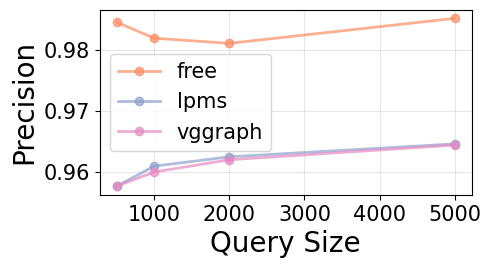

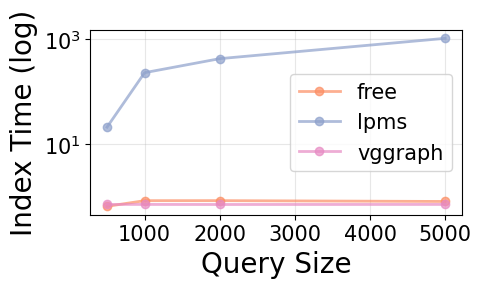

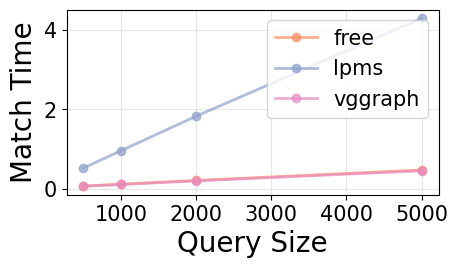

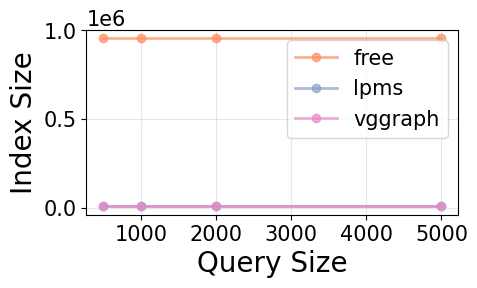

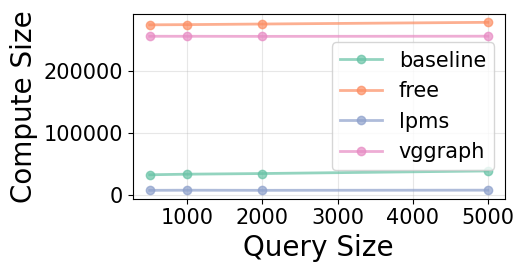

In [40]:
if not synthetic_res_df.empty:
    # Example: Fix dataset_size=10000, selectivity=0.1, vary query_size
    available_dataset_sizes = sorted(synthetic_res_df['dataset_size'].unique())
    
    fixed_params_2 = {'dataset_size': 50000, 'synthetic_selectivity': 0.5}
    
    # Use available values if defaults aren't present
    if 10000 not in available_dataset_sizes and available_dataset_sizes:
        fixed_params_2['dataset_size'] = available_dataset_sizes[len(available_dataset_sizes)//2]
    if 0.1 not in available_selectivities and available_selectivities:
        fixed_params_2['synthetic_selectivity'] = available_selectivities[len(available_selectivities)//2]
    
    print(f"Using fixed parameters: {fixed_params_2}")
    
    grouped_query = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='query_size', 
        fixed_params=fixed_params_2
    )
    
    if grouped_query is not None:
        plot_synthetic_analysis(grouped_query, 'query_size', fixed_params_2)
else:
    print("No synthetic data available for query size analysis")

## Analysis 3: Varying Selectivity

Fix dataset size and query size, vary selectivity to see impact of query difficulty.

Using fixed parameters: {'dataset_size': 50000, 'query_size': 500}
Analyzing 94 experiments varying synthetic_selectivity
Fixed parameters: {'dataset_size': 50000, 'query_size': 500}
Varying synthetic_selectivity: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5]


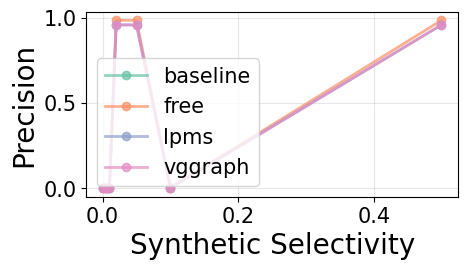

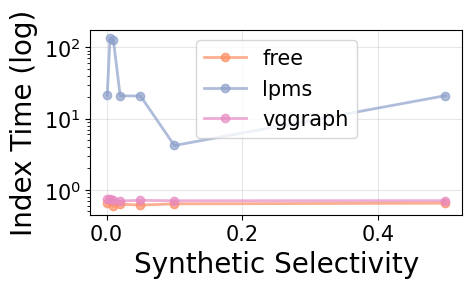

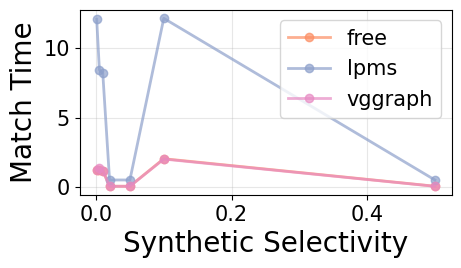

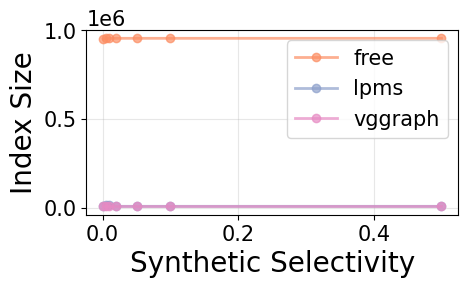

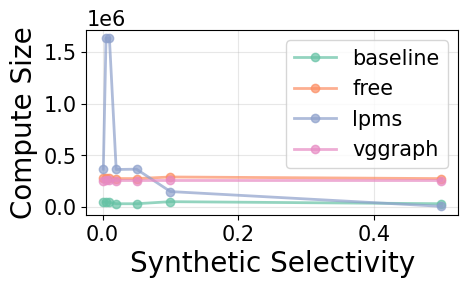

In [38]:
if not synthetic_res_df.empty:
    # Example: Fix dataset_size=10000, query_size=1000, vary selectivity
    fixed_params_3 = {'dataset_size': 10000, 'query_size': 500}
    
    # Use available values if defaults aren't present
    if 10000 not in available_dataset_sizes and available_dataset_sizes:
        fixed_params_3['dataset_size'] = available_dataset_sizes[len(available_dataset_sizes)//2]
    if 1000 not in available_query_sizes and available_query_sizes:
        fixed_params_3['query_size'] = available_query_sizes[len(available_query_sizes)//2]
    
    print(f"Using fixed parameters: {fixed_params_3}")
    
    grouped_selectivity = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='synthetic_selectivity', 
        fixed_params=fixed_params_3
    )
    
    if grouped_selectivity is not None:
        plot_synthetic_analysis(grouped_selectivity, 'synthetic_selectivity', fixed_params_3)
else:
    print("No synthetic data available for selectivity analysis")

## Summary Analysis

Overall comparison across all synthetic workload configurations.

In [39]:
if not synthetic_res_df.empty:
    # Overall summary statistics
    print("=== Synthetic Workload Summary ===")
    print(f"Total configurations analyzed: {len(synthetic_res_df)}")
    print(f"Methods tested: {sorted(synthetic_res_df['method'].unique())}")
    print(f"Dataset size range: {synthetic_res_df['dataset_size'].min()} - {synthetic_res_df['dataset_size'].max()}")
    print(f"Query size range: {synthetic_res_df['query_size'].min()} - {synthetic_res_df['query_size'].max()}")
    print(f"Selectivity range: {synthetic_res_df['synthetic_selectivity'].min():.3f} - {synthetic_res_df['synthetic_selectivity'].max():.3f}")
    
    # Method comparison across all configurations
    print("\n=== Method Performance Summary ===")
    method_summary = synthetic_res_df.groupby('method').agg({
        'precision': ['mean', 'std', 'min', 'max'],
        'overall_index_time': ['mean', 'std', 'min', 'max'],
        'overall_match_time': ['mean', 'std', 'min', 'max'],
        'index_size': ['mean', 'std', 'min', 'max'],
        'compute_size': ['mean', 'std', 'min', 'max']
    }).round(3)
    
    print(method_summary)
    
    # Best method for each metric
    print("\n=== Best Method by Metric ===")
    metrics = ['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']
    best_methods = {}
    
    for metric in metrics:
        if metric in synthetic_res_df.columns:
            if metric == 'precision':
                best_idx = synthetic_res_df.groupby('method')[metric].mean().idxmax()
                best_val = synthetic_res_df.groupby('method')[metric].mean().max()
            else:
                # For time and size metrics, lower is better
                valid_data = synthetic_res_df[synthetic_res_df[metric] > 0]
                if not valid_data.empty:
                    best_idx = valid_data.groupby('method')[metric].mean().idxmin()
                    best_val = valid_data.groupby('method')[metric].mean().min()
                else:
                    best_idx, best_val = "N/A", "N/A"
            
            best_methods[metric] = (best_idx, best_val)
            print(f"{metric}: {best_idx} ({best_val})")
else:
    print("No synthetic data available for summary analysis")

=== Synthetic Workload Summary ===
Total configurations analyzed: 133
Methods tested: ['baseline', 'free', 'lpms', 'vggraph']
Dataset size range: 50000 - 50000
Query size range: 500 - 5000
Selectivity range: 0.001 - 0.500

=== Method Performance Summary ===
          precision                              overall_index_time           \
               mean        std        min    max               mean      std   
method                                                                         
baseline -28897.723  23592.684 -48220.036 -0.000             -1.000    0.000   
free          0.591      0.507      0.000  0.985              0.696    0.095   
lpms          0.576      0.495      0.000  0.965            202.813  318.857   
vggraph       0.576      0.495      0.000  0.964              0.718    0.021   

                          overall_match_time                       index_size  \
            min       max               mean    std    min     max       mean   
method             

## Instructions for Customization

To use this analysis with your specific synthetic workload data:

1. **Update the path**: Change `synthetic_root_dir` to point to your results directory
2. **Verify folder naming**: Ensure your folders follow the pattern `synthetic2_{datasetSize}_{querySize}_{selectivity}_{methodName}_{suffix}`
3. **Update parameter ranges**: Modify the lists in the configuration section to match your actual data:
   - `DATASET_SIZES`
   - `QUERY_SIZES` 
   - `SELECTIVITIES`
   - `SYNTHETIC_METHODS`
4. **Customize fixed parameters**: In each analysis section, adjust the `fixed_params` dictionaries to use values that exist in your data
5. **Add more analyses**: Create additional analysis sections by calling `analyze_synthetic_by_parameter()` and `plot_synthetic_analysis()` with different parameter combinations

The code will automatically discover available folders and adapt to the actual parameter values found in your data.